In [1]:
import torch
from torch import nn
from d2l import torch as d2l

def dropout_layer(X,dropout):
    assert 0<=dropout<=1
    if dropout==1:      # 在本情况中,所有元素都被丢弃
        return torch.zeros_like(X)
    if dropout==0:      # 在本情况中,所有元素都被保留
        return X
    mask=(torch.rand(X.shape)>dropout).float()
    return mask*X/(1.0-dropout)

X=torch.arange(16,dtype=torch.float32).reshape((2,8))
print(X)
print(dropout_layer(X,0))
print(dropout_layer(X,0.5))
print(dropout_layer(X,1))

tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15.]])
tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15.]])
tensor([[ 0.,  0.,  0.,  6.,  0., 10.,  0.,  0.],
        [16.,  0.,  0., 22.,  0., 26.,  0.,  0.]])
tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]])


In [2]:
num_inputs,num_outputs,num_hidden1,num_hidden2=784,10,256,256
dropout1,dropout2=0.2,0.5

class Net(nn.Module):
    def __init__(self,num_inputs,num_outputs,num_hidden1,num_hidden2,is_training=True):
        super(Net,self).__init__()
        self.num_inputs=num_inputs
        self.training=is_training
        self.lin1=nn.Linear(num_inputs,num_hidden1)
        self.lin2=nn.Linear(num_hidden1,num_hidden2)
        self.lin3=nn.Linear(num_hidden2,num_outputs)
        self.relu=nn.ReLU()
    def forward(self,X):
        H1=self.relu(self.lin1(X.reshape((-1,self.num_inputs))))
        # 只有在训练模型时才使用dropout
        if self.training==True:
            H1=dropout_layer(H1,dropout1)   # 在第一个全连接层之后添加一个dropout层
        H2=self.relu(self.lin2(H1))
        if self.training==True:
            H2=dropout_layer(H2,dropout2)   # 在第二个全连接层之后添加一个dropout层
        out=self.lin3(H2)
        return out

net=Net(num_inputs,num_outputs,num_hidden1,num_hidden2,is_training=True)

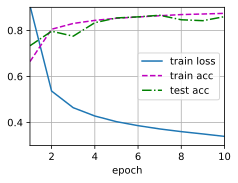

In [3]:
num_epochs,lr,batch_size=10,0.5,256
loss=nn.CrossEntropyLoss(reduction='none')
train_iter,test_iter=d2l.load_data_fashion_mnist(batch_size)
trainer=torch.optim.SGD(net.parameters(),lr=lr)
d2l.train_ch3(net,train_iter,test_iter,loss,num_epochs,trainer)

简洁实现

In [4]:
net=nn.Sequential(nn.Flatten(),
                  nn.Linear(784,256),
                  nn.ReLU(),
                  nn.Dropout(dropout1),
                  nn.Linear(256,256),
                  nn.ReLU(),
                  nn.Dropout(dropout2),
                  nn.Linear(256,10))

def init_weights(m):
    if type(m)==nn.Linear:
        nn.init.normal_(m.weight,std=0.01)

net.apply(init_weights)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): ReLU()
  (3): Dropout(p=0.2, inplace=False)
  (4): Linear(in_features=256, out_features=256, bias=True)
  (5): ReLU()
  (6): Dropout(p=0.5, inplace=False)
  (7): Linear(in_features=256, out_features=10, bias=True)
)

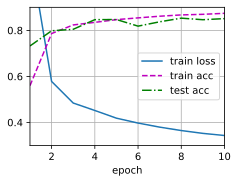

In [5]:
trainer=torch.optim.SGD(net.parameters(),lr=lr)
d2l.train_ch3(net,train_iter,test_iter,loss,num_epochs,trainer)

Exercises

隐藏层激活值的方差随迭代周期的变化

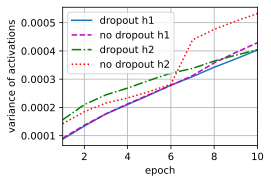

In [36]:
net_dropout=nn.Sequential(nn.Flatten(),
                          nn.Linear(784,256),
                          nn.ReLU(),
                          nn.Dropout(dropout1),
                          nn.Linear(256,256),
                          nn.ReLU(),
                          nn.Dropout(dropout2),
                          nn.Linear(256,10))

net_nodropout=nn.Sequential(nn.Flatten(),
                            nn.Linear(784,256),
                            nn.ReLU(),
                            nn.Linear(256,256),
                            nn.ReLU(),
                            nn.Linear(256,10))
def var_hidden(net):
    with torch.no_grad():
        return [layer.weight.relu().var().item() for layer in net[:-1] if isinstance(layer,nn.Linear)]

def train(net1,net2,train_iter,test_iter,loss,num_epochs):
    net1.apply(init_weights)
    net2.apply(init_weights)
    trainer1=torch.optim.SGD(net1.parameters(),lr=0.5)
    trainer2=torch.optim.SGD(net2.parameters(),lr=0.5)
    animator=d2l.Animator(xlabel='epoch',ylabel='variance of activations',xlim=[1,num_epochs],legend=['dropout h1','no dropout h1','dropout h2','no dropout h2'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net1,train_iter,loss,trainer1)
        d2l.train_epoch_ch3(net2,train_iter,loss,trainer2)
        animator.add(epoch+1,[i for pair in zip(var_hidden(net1),var_hidden(net2)) for i in pair])

train(net_dropout,net_nodropout,train_iter,test_iter,loss,num_epochs)

比较使用Dropout、权重衰减和二者同时使用的效果

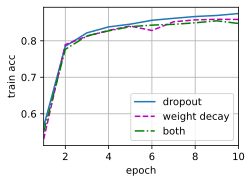

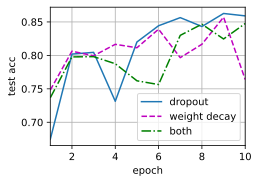

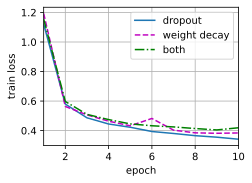

In [43]:
import copy

net_dropout=nn.Sequential(nn.Flatten(),
                          nn.Linear(784,256),
                          nn.ReLU(),
                          nn.Dropout(dropout1),
                          nn.Linear(256,256),
                          nn.ReLU(),
                          nn.Dropout(dropout2),
                          nn.Linear(256,10))

net_weight_dacay=nn.Sequential(nn.Flatten(),
                               nn.Linear(784,256),
                               nn.ReLU(),
                               nn.Linear(256,256),
                               nn.ReLU(),
                               nn.Linear(256,10))

net_both=copy.deepcopy(net_dropout)

def train_2(net1,net2,net3,train_iter,test_iter,loss,num_epochs):
    net1.apply(init_weights)
    net2.apply(init_weights)
    net3.apply(init_weights)
    trainer1=torch.optim.SGD(net1.parameters(),lr=0.5)
    trainer2=torch.optim.SGD(net2.parameters(),lr=0.5,weight_decay=1e-3)
    trainer3=torch.optim.SGD(net3.parameters(),lr=0.5,weight_decay=1e-3)
    animator1=d2l.Animator(xlabel='epoch',ylabel='train acc',xlim=[1,num_epochs],legend=['dropout','weight decay','both'])
    animator2=d2l.Animator(xlabel='epoch',ylabel='test acc',xlim=[1,num_epochs],legend=['dropout','weight decay','both'])
    animator3=d2l.Animator(xlabel='epoch',ylabel='train loss',xlim=[1,num_epochs],legend=['dropout','weight decay','both'])
    for epoch in range(num_epochs):
        train_loss_1,train_acc_1=d2l.train_epoch_ch3(net1,train_iter,loss,trainer1)
        train_loss_2,train_acc_2=d2l.train_epoch_ch3(net2,train_iter,loss,trainer2)
        train_loss_3,train_acc_3=d2l.train_epoch_ch3(net3,train_iter,loss,trainer3)
        animator1.add(epoch+1,[train_acc_1,train_acc_2,train_acc_3])
        animator2.add(epoch+1,[d2l.evaluate_accuracy(net1,test_iter),d2l.evaluate_accuracy(net2,test_iter),d2l.evaluate_accuracy(net3,test_iter)])
        animator3.add(epoch+1,[train_loss_1,train_loss_2,train_loss_3])

train_2(net_dropout,net_weight_dacay,net_both,train_iter,test_iter,loss,num_epochs)

一种新的暂退法(高斯噪声，不过存在数值稳定性问题)

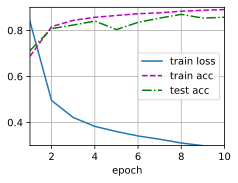

In [62]:
class Net_2(nn.Module):
    def __init__(self,num_inputs,num_outputs,num_hidden1,num_hidden2,is_training=True):
        super(Net_2,self).__init__()
        self.num_inputs=num_inputs
        self.training=is_training
        self.lin1=nn.Linear(num_inputs,num_hidden1)
        self.lin2=nn.Linear(num_hidden1,num_hidden2)
        self.lin3=nn.Linear(num_hidden2,num_outputs)
        self.relu=nn.ReLU()
    def forward(self,X):
        H1=self.relu(self.lin1(X.reshape((-1,self.num_inputs))))
        if self.training==True:
            H1=H1+torch.randn(H1.shape)*0.01
        H2=self.relu(self.lin2(H1))
        if self.training==True:
            H2=H2+torch.randn(H2.shape)*0.05
        out=self.lin3(H2)
        return out

net_2=Net_2(num_inputs,num_outputs,num_hidden1,num_hidden2,is_training=True)
trainer=torch.optim.SGD(net_2.parameters(),lr=0.5)
d2l.train_ch3(net_2,train_iter,test_iter,loss,num_epochs,trainer)